# **Building Music Recommendation System using Spotify Dataset**

## **Group 13**

Anish George <br>
Drishya P Suresh <br>
Sashank Konathala <br>
Shora Ngarambe <br>

In [ ]:
!pip install spotipy
!pip install python-decouple

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Imports**

In [ ]:
import os
import numpy as np
import pandas as pd
import ast

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.cluster import InterclusterDistance
import difflib
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

from yellowbrick.target import FeatureCorrelation
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.classifier import ConfusionMatrix

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

from decouple import config
import joblib

import warnings
warnings.filterwarnings("ignore")

# **Custom Functions**

In [ ]:
def optimal_cluster_elbow_method(data):
  wcss = []
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(data)
  for i in range(1, 25):
      kmeans = KMeans(n_clusters=i, init='k-means++',random_state=0)
      kmeans.fit(X_scaled)
      wcss.append(kmeans.inertia_)
  plt.figure(figsize=(5, 5))
  plt.plot(range(1, 25), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.show()

# **Cleaning Dataset**

In [ ]:
if not(os.path.exists("GNG5125-Dataset")):
  !git clone https://github.com/ANISHG-26/GNG5125-Dataset.git

In [ ]:
os.chdir('/content')

In [ ]:
original_data_directory = "GNG5125-Dataset/"
os.chdir(original_data_directory)

## **Read Files**

In [ ]:
df_data = pd.read_csv('data.csv')
df_artist = pd.read_csv('data_by_artist.csv')
df_genres = pd.read_csv('data_by_genres.csv')
df_year = pd.read_csv('data_by_year.csv')
df_extend_genre = pd.read_csv('data_w_genres.csv')

## **Remove Nulls**

In [ ]:
df_data = df_data[df_data['artists'].notna()][df_data['year']>=1960]
df_artist = df_artist[df_artist['artists'].notna()]
df_genres = df_genres[df_genres['genres'].notna()]
df_year = df_year[df_year['year'].notna()][df_year['year']>=1960]
df_extend_genre = df_extend_genre[df_extend_genre['genres'].notna()]

## **Remove Empty Entries**

In [ ]:
df_extend_genre.drop(df_extend_genre[df_extend_genre['genres']=="[]"].index, inplace=True)
df_genres.drop(df_genres[df_genres['genres']=="[]"].index, inplace=True)

## **Save Cleaned Files**

In [ ]:
os.chdir('/content')
if not(os.path.exists("Cleaned-Data")):
  os.mkdir("Cleaned-Data")

cleaned_data_file_path = "Cleaned-Data"

os.chdir(cleaned_data_file_path)

df_data.to_csv('clean_by_main_data.csv')
df_artist.to_csv('clean_by_artists.csv')
df_genres.to_csv('clean_by_genres.csv')
df_year.to_csv('clean_by_year.csv')
df_extend_genre.to_csv('clean_by_extended_genre.csv')

os.chdir('/content')

In [ ]:
os.chdir(cleaned_data_file_path)

# **Information about the dataset files**

data.csv - Has a list of all the songs with artist name and other properties.

data_by_genre - Has a list of all the genres and the general characteristic of each genre.

data_by_year - Has a list of all the song years and the general characteristic of the songs in that particular year. Indicates year specific properties.

data_by_artist - Has a list of all the artists and the general characteristic of the artist.

data_w_genre - Combines the artists and the genres of the songs the artists produce music in. It also has metrics for the same.





In [ ]:
data = pd.read_csv('clean_by_main_data.csv')
data  = data.loc[:, ~data.columns.str.contains('^Unnamed')]

genre_data = pd.read_csv('clean_by_genres.csv')
genre_data  = genre_data.loc[:, ~genre_data.columns.str.contains('^Unnamed')]

year_data = pd.read_csv('clean_by_year.csv')
year_data  = year_data.loc[:, ~year_data.columns.str.contains('^Unnamed')]

artist_data = pd.read_csv('clean_by_artists.csv')
artist_data  = artist_data.loc[:, ~artist_data.columns.str.contains('^Unnamed')]

genre_w_data = pd.read_csv('clean_by_extended_genre.csv')
genre_w_data  = genre_w_data.loc[:, ~genre_w_data.columns.str.contains('^Unnamed')]



In [ ]:
os.chdir('/content')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           120750 non-null  float64
 1   year              120750 non-null  int64  
 2   acousticness      120750 non-null  float64
 3   artists           120750 non-null  object 
 4   danceability      120750 non-null  float64
 5   duration_ms       120750 non-null  int64  
 6   energy            120750 non-null  float64
 7   explicit          120750 non-null  int64  
 8   id                120750 non-null  object 
 9   instrumentalness  120750 non-null  float64
 10  key               120750 non-null  int64  
 11  liveness          120750 non-null  float64
 12  loudness          120750 non-null  float64
 13  mode              120750 non-null  int64  
 14  name              120750 non-null  object 
 15  popularity        120750 non-null  int64  
 16  release_date      12

In [ ]:
data.head(5)

valence  year  acousticness              artists  danceability  \
0    0.328  1960         0.547       ['Etta James']         0.274   
1    0.402  1960         0.829       ['Etta James']         0.421   
2    0.644  1960         0.764  ['Ella Fitzgerald']         0.508   
3    0.836  1960         0.733  ['Ella Fitzgerald']         0.579   
4    0.965  1960         0.699      ['Neil Sedaka']         0.743   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       179693   0.348         0  4Hhv2vrOTy89HFRcjU3QOx          0.013300   
1       196133   0.285         0  0zGLlXbHlrAyBN1x6sY0rb          0.000002   
2       175987   0.287         0  4ukUoXLuFzMixyZyabSGc4          0.000000   
3       131733   0.502         0  65irrLqfCMRiO3p87P4C0D          0.000000   
4       139200   0.799         0  2x6pbpjVGjiWCcH89IK8AX          0.000000   

   key  liveness  loudness  mode                       name  popularity  \
0    5    0.3340    -8.631     1                    At Last          76   
1    2    0.2330    -9.430     0      A Sunday Kind Of Love          70   
2    1    0.1530   -12.472     1                Sleigh Ride          69   
3    8    0.2810    -7.570     1         Frosty The Snowman          69   
4    8    0.0635    -5.466     0  Breaking Up Is Hard to Do          62   

  release_date  speechiness    tempo  
0         1960       0.0293   87.430  
1         1960       0.0293   85.861  
2   1960-01-01       0.0523  154.759  
3   1960-01-01       0.0513   76.816  
4   1960-12-30       0.0375  116.112

In [ ]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2972 non-null   int64  
 1   genres            2972 non-null   object 
 2   acousticness      2972 non-null   float64
 3   danceability      2972 non-null   float64
 4   duration_ms       2972 non-null   float64
 5   energy            2972 non-null   float64
 6   instrumentalness  2972 non-null   float64
 7   liveness          2972 non-null   float64
 8   loudness          2972 non-null   float64
 9   speechiness       2972 non-null   float64
 10  tempo             2972 non-null   float64
 11  valence           2972 non-null   float64
 12  popularity        2972 non-null   float64
 13  key               2972 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.2+ KB


In [ ]:
genre_data.head(5)

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1              a cappella      0.676557      0.538961  1.906285e+05   
4     1                abstract      0.459210      0.516167  3.431965e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   
4  0.442417          0.849667  0.118067 -15.472083     0.046517  127.885750   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5  
2  0.975000   48.000000    7  
3  0.448249   45.820071    7  
4  0.307325   43.500000    1

In [ ]:
year_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              61 non-null     int64  
 1   year              61 non-null     int64  
 2   acousticness      61 non-null     float64
 3   danceability      61 non-null     float64
 4   duration_ms       61 non-null     float64
 5   energy            61 non-null     float64
 6   instrumentalness  61 non-null     float64
 7   liveness          61 non-null     float64
 8   loudness          61 non-null     float64
 9   speechiness       61 non-null     float64
 10  tempo             61 non-null     float64
 11  valence           61 non-null     float64
 12  popularity        61 non-null     float64
 13  key               61 non-null     int64  
dtypes: float64(11), int64(3)
memory usage: 6.8 KB


In [ ]:
year_data.head(5)

mode  year  acousticness  danceability    duration_ms    energy  \
0     1  1960      0.767181      0.486029  210209.683784  0.341142   
1     1  1961      0.751904      0.489166  232186.614211  0.339532   
2     1  1962      0.720608      0.493164  209294.413158  0.371026   
3     1  1963      0.722705      0.481621  200510.548500  0.365354   
4     1  1964      0.694101      0.504177  195536.411795  0.394439   

   instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0          0.176502  0.207864 -13.814103     0.065784  112.561679  0.523932   
1          0.264623  0.208913 -14.171331     0.059476  111.808958  0.512851   
2          0.171472  0.201896 -13.177364     0.057740  114.841005  0.547792   
3          0.185432  0.203745 -13.670647     0.052036  114.324587  0.541527   
4          0.159598  0.217232 -13.048076     0.066594  115.081489  0.557260   

   popularity  key  
0   19.783784    0  
1   19.598421    0  
2   22.127368    0  
3   25.535500    0  
4   26.321026    0

In [ ]:
artist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              28680 non-null  int64  
 1   count             28680 non-null  int64  
 2   acousticness      28680 non-null  float64
 3   artists           28680 non-null  object 
 4   danceability      28680 non-null  float64
 5   duration_ms       28680 non-null  float64
 6   energy            28680 non-null  float64
 7   instrumentalness  28680 non-null  float64
 8   liveness          28680 non-null  float64
 9   loudness          28680 non-null  float64
 10  speechiness       28680 non-null  float64
 11  tempo             28680 non-null  float64
 12  valence           28680 non-null  float64
 13  popularity        28680 non-null  float64
 14  key               28680 non-null  int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 3.3+ MB


In [ ]:
artist_data.head(5)

mode  count  acousticness  \
0     1      9      0.590111   
1     1     26      0.862538   
2     1      7      0.856571   
3     1     27      0.884926   
4     1      7      0.510714   

                                             artists  danceability  \
0                   "Cats" 1981 Original London Cast      0.467222   
1                          "Cats" 1983 Broadway Cast      0.441731   
2        "Fiddler On The Roof” Motion Picture Chorus      0.348286   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.425074   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.467143   

     duration_ms    energy  instrumentalness  liveness   loudness  \
0  250318.555556  0.394003          0.011400  0.290833 -14.448000   
1  287280.000000  0.406808          0.081158  0.315215 -10.690000   
2  328920.000000  0.286571          0.024593  0.325786 -15.230714   
3  262890.962963  0.245770          0.073587  0.275481 -15.639370   
4  270436.142857  0.488286          0.009400  0.195000 -10.236714   

   speechiness       tempo   valence  popularity  key  
0     0.210389  117.518111  0.389500   38.333333    5  
1     0.176212  103.044154  0.268865   30.576923    5  
2     0.118514   77.375857  0.354857   34.857143    0  
3     0.123200   88.667630  0.372030   34.851852    0  
4     0.098543  122.835857  0.482286   43.000000    5

In [ ]:
from google.colab import files
files.download('clustered_song_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
genre_w_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18823 entries, 0 to 18822
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            18823 non-null  object 
 1   artists           18823 non-null  object 
 2   acousticness      18823 non-null  float64
 3   danceability      18823 non-null  float64
 4   duration_ms       18823 non-null  float64
 5   energy            18823 non-null  float64
 6   instrumentalness  18823 non-null  float64
 7   liveness          18823 non-null  float64
 8   loudness          18823 non-null  float64
 9   speechiness       18823 non-null  float64
 10  tempo             18823 non-null  float64
 11  valence           18823 non-null  float64
 12  popularity        18823 non-null  float64
 13  key               18823 non-null  int64  
 14  mode              18823 non-null  int64  
 15  count             18823 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

In [ ]:
genre_w_data.head(5)

genres  \
0                                     ['show tunes']   
1                 ['comedy rock', 'comic', 'parody']   
2  ['emo rap', 'florida rap', 'sad rap', 'undergr...   
3                          ['dark trap', 'meme rap']   
4  ['asian american hip hop', 'cali rap', 'west c...   

                            artists  acousticness  danceability  \
0  "Cats" 1981 Original London Cast      0.590111      0.467222   
1               "Weird Al" Yankovic      0.173145      0.662787   
2                              $NOT      0.544467      0.789800   
3                       $atori Zoom      0.239000      0.883000   
4                      $tupid Young      0.148100      0.854000   

     duration_ms    energy  instrumentalness  liveness   loudness  \
0  250318.555556  0.394003          0.011400  0.290833 -14.448000   
1  218948.196721  0.695393          0.000050  0.161102  -9.768705   
2  137910.466667  0.532933          0.023063  0.180300  -9.149267   
3  141519.000000  0.625000          0.000000  0.076500  -4.098000   
4  190572.000000  0.683000          0.000002  0.188500  -6.997000   

   speechiness       tempo   valence  popularity  key  mode  count  
0     0.210389  117.518111  0.389500   38.333333    5     1      9  
1     0.084536  133.031180  0.751344   34.229508    9     1    122  
2     0.293687  112.344800  0.480700   67.533333    1     1     15  
3     0.245000  126.677000  0.871000   67.000000    6     1      2  
4     0.221000  100.724500  0.625500   57.500000    1     1      2

# **Exploratory Data Analysis**

## **About the different musical properties**

**Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. Range: 0 - 1

**Danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**Duration in Milliseconds:** The duration of the track in milliseconds.

**Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**ID:** The Spotify ID for the track.

**Instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**Key:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. Range: -1 - 11

**Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

**Mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**Speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

**Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). Range: 0 - 1

**Time Signature (Not Used):** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". Range: 3 - 7


**Link to information:** https://developer.spotify.com/documentation/web-api/reference/get-audio-features

## **Looking at trends in songs across the decades (data_by_year.csv)**

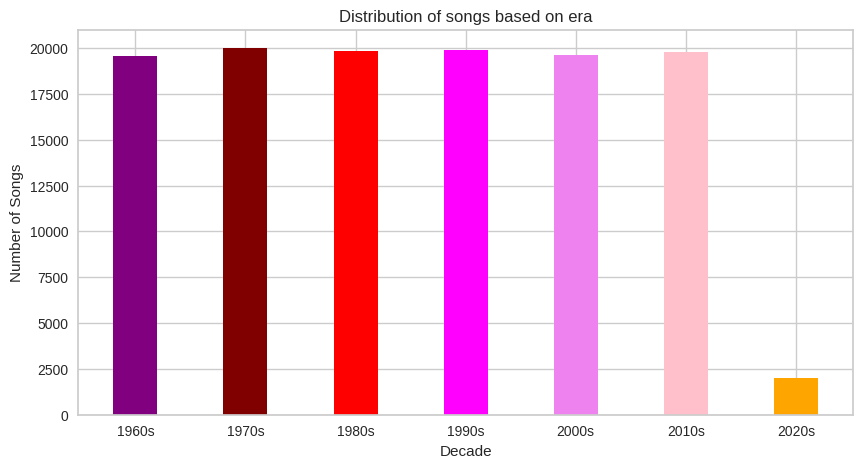

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)

song_count_series = data['decade'].value_counts().sort_index(ascending=True)
song_count = song_count_series.to_list()
era = song_count_series.index.to_list()
for item in era:
  era[era.index(item)] = item +"s"
era

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(era, song_count, color =['purple','maroon', 'red', 'magenta', 'violet', 'pink', 'orange','yellow', 'cyan', 'teal', 'blue'],
        width = 0.4)
 
plt.xlabel("Decade")
plt.ylabel("Number of Songs")
plt.title("Distribution of songs based on era")
plt.show()

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

## **Looking at the most popular genres in the data_by_genre.csv**

In [ ]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

## **Looking at the most popular artists in the data_by_artist.csv**

In [ ]:
top10_artists = artist_data.nlargest(10, 'popularity')

fig = px.bar(top10_artists, x='artists', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

## **Pearson Correlation on data.csv**

This section gives us a general idea of what features of the songs in the dataset (data.csv) make a song popular

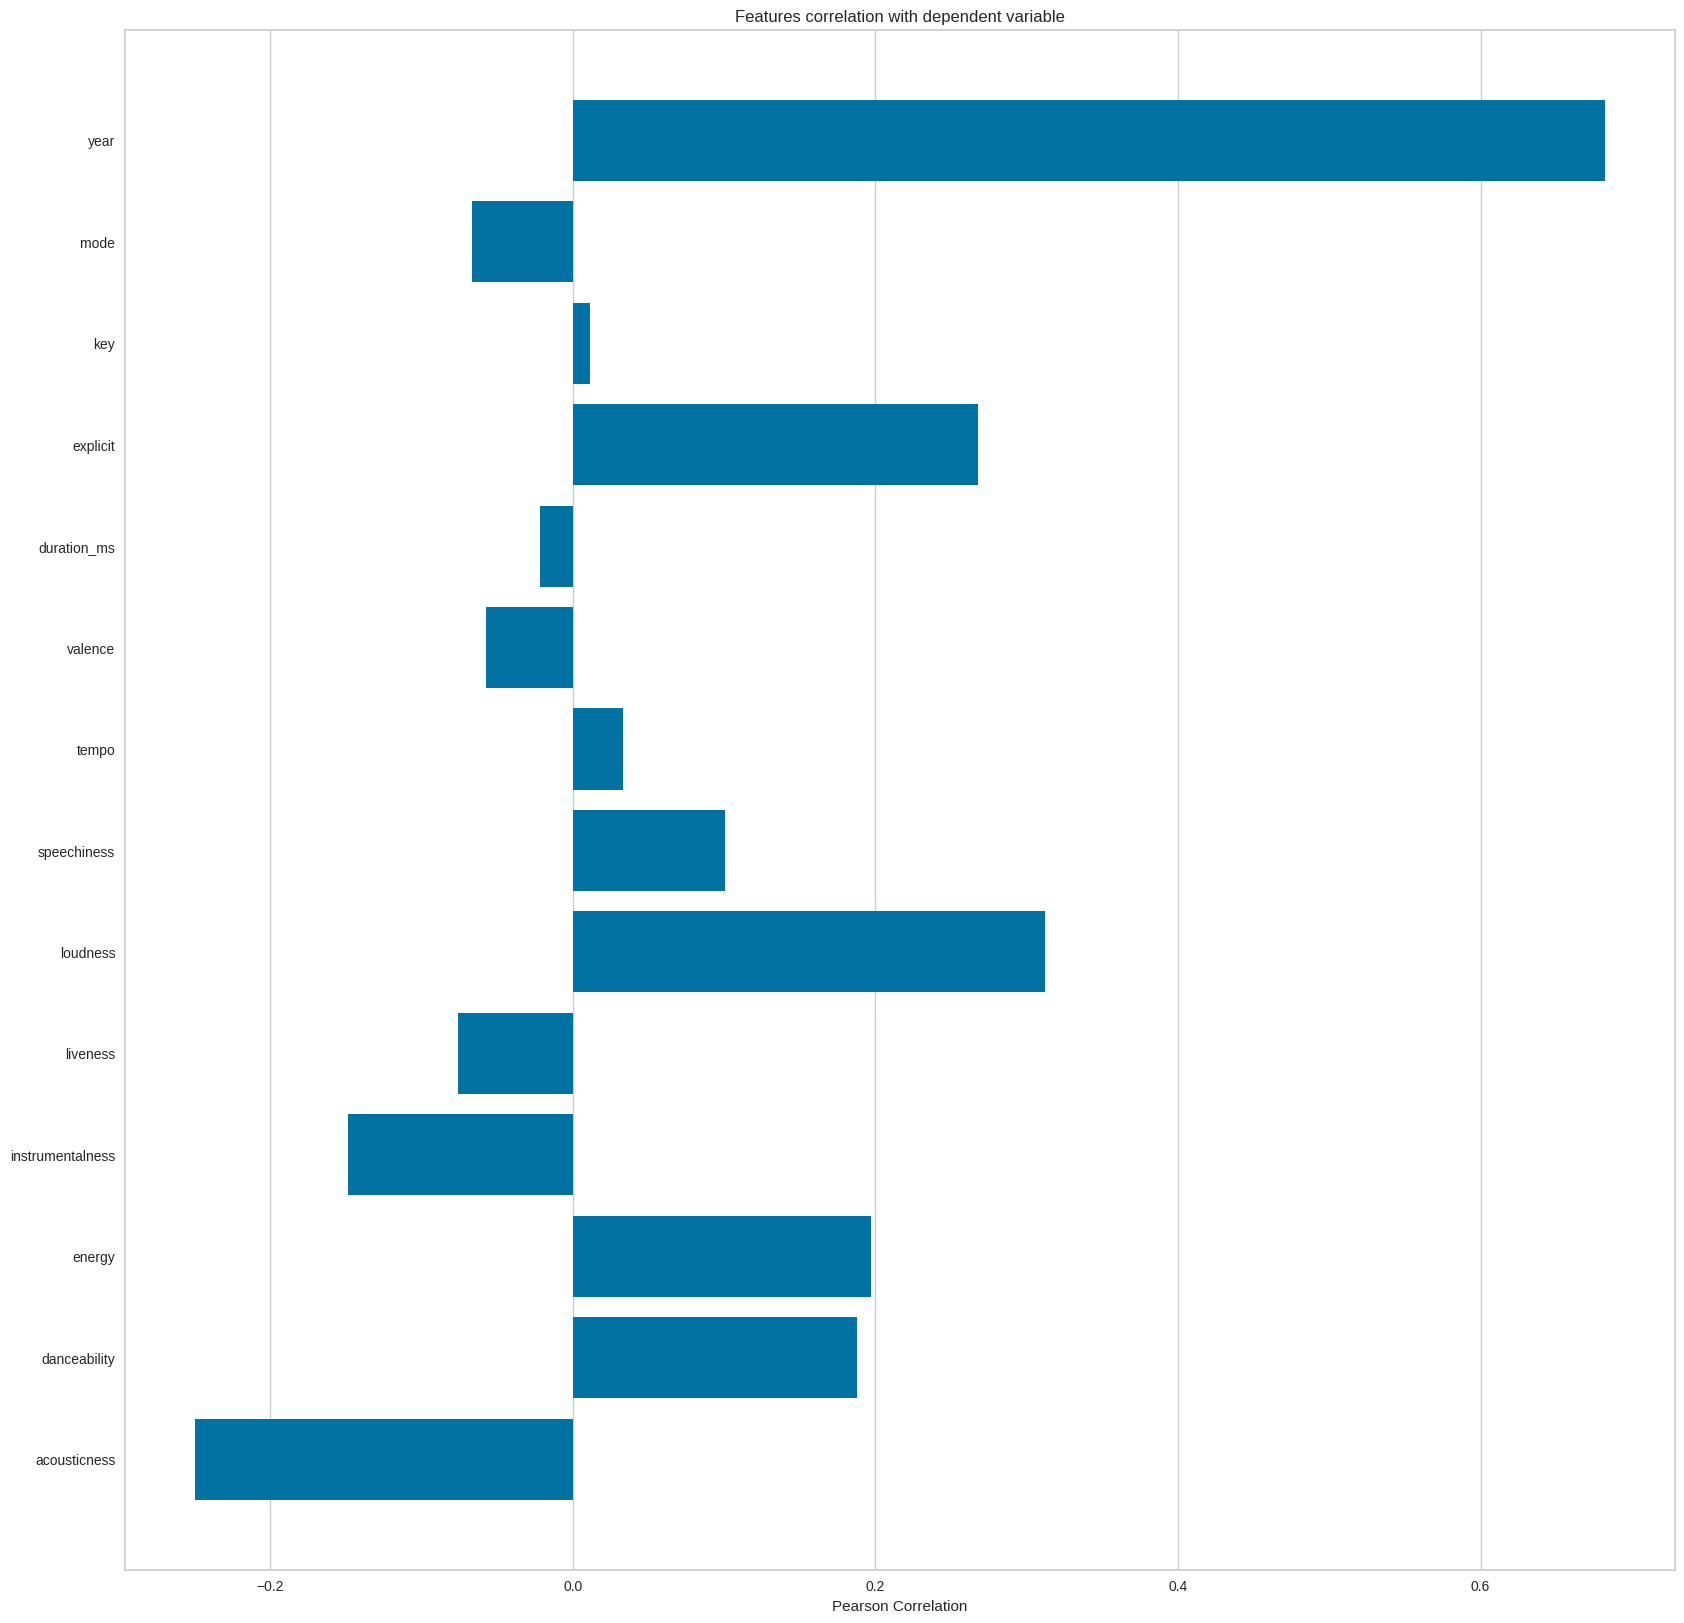

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
feature_names_song = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names_song], data['popularity']

# Create a list of the feature names
features = np.array(feature_names_song)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

The song properties that make a song popular - Explicit, Tempo, Loudness, Energy, Danceability

## **Pearson Correlation on data_by_genre.csv**

This section gives us a general idea of what features of help make a genre distinct

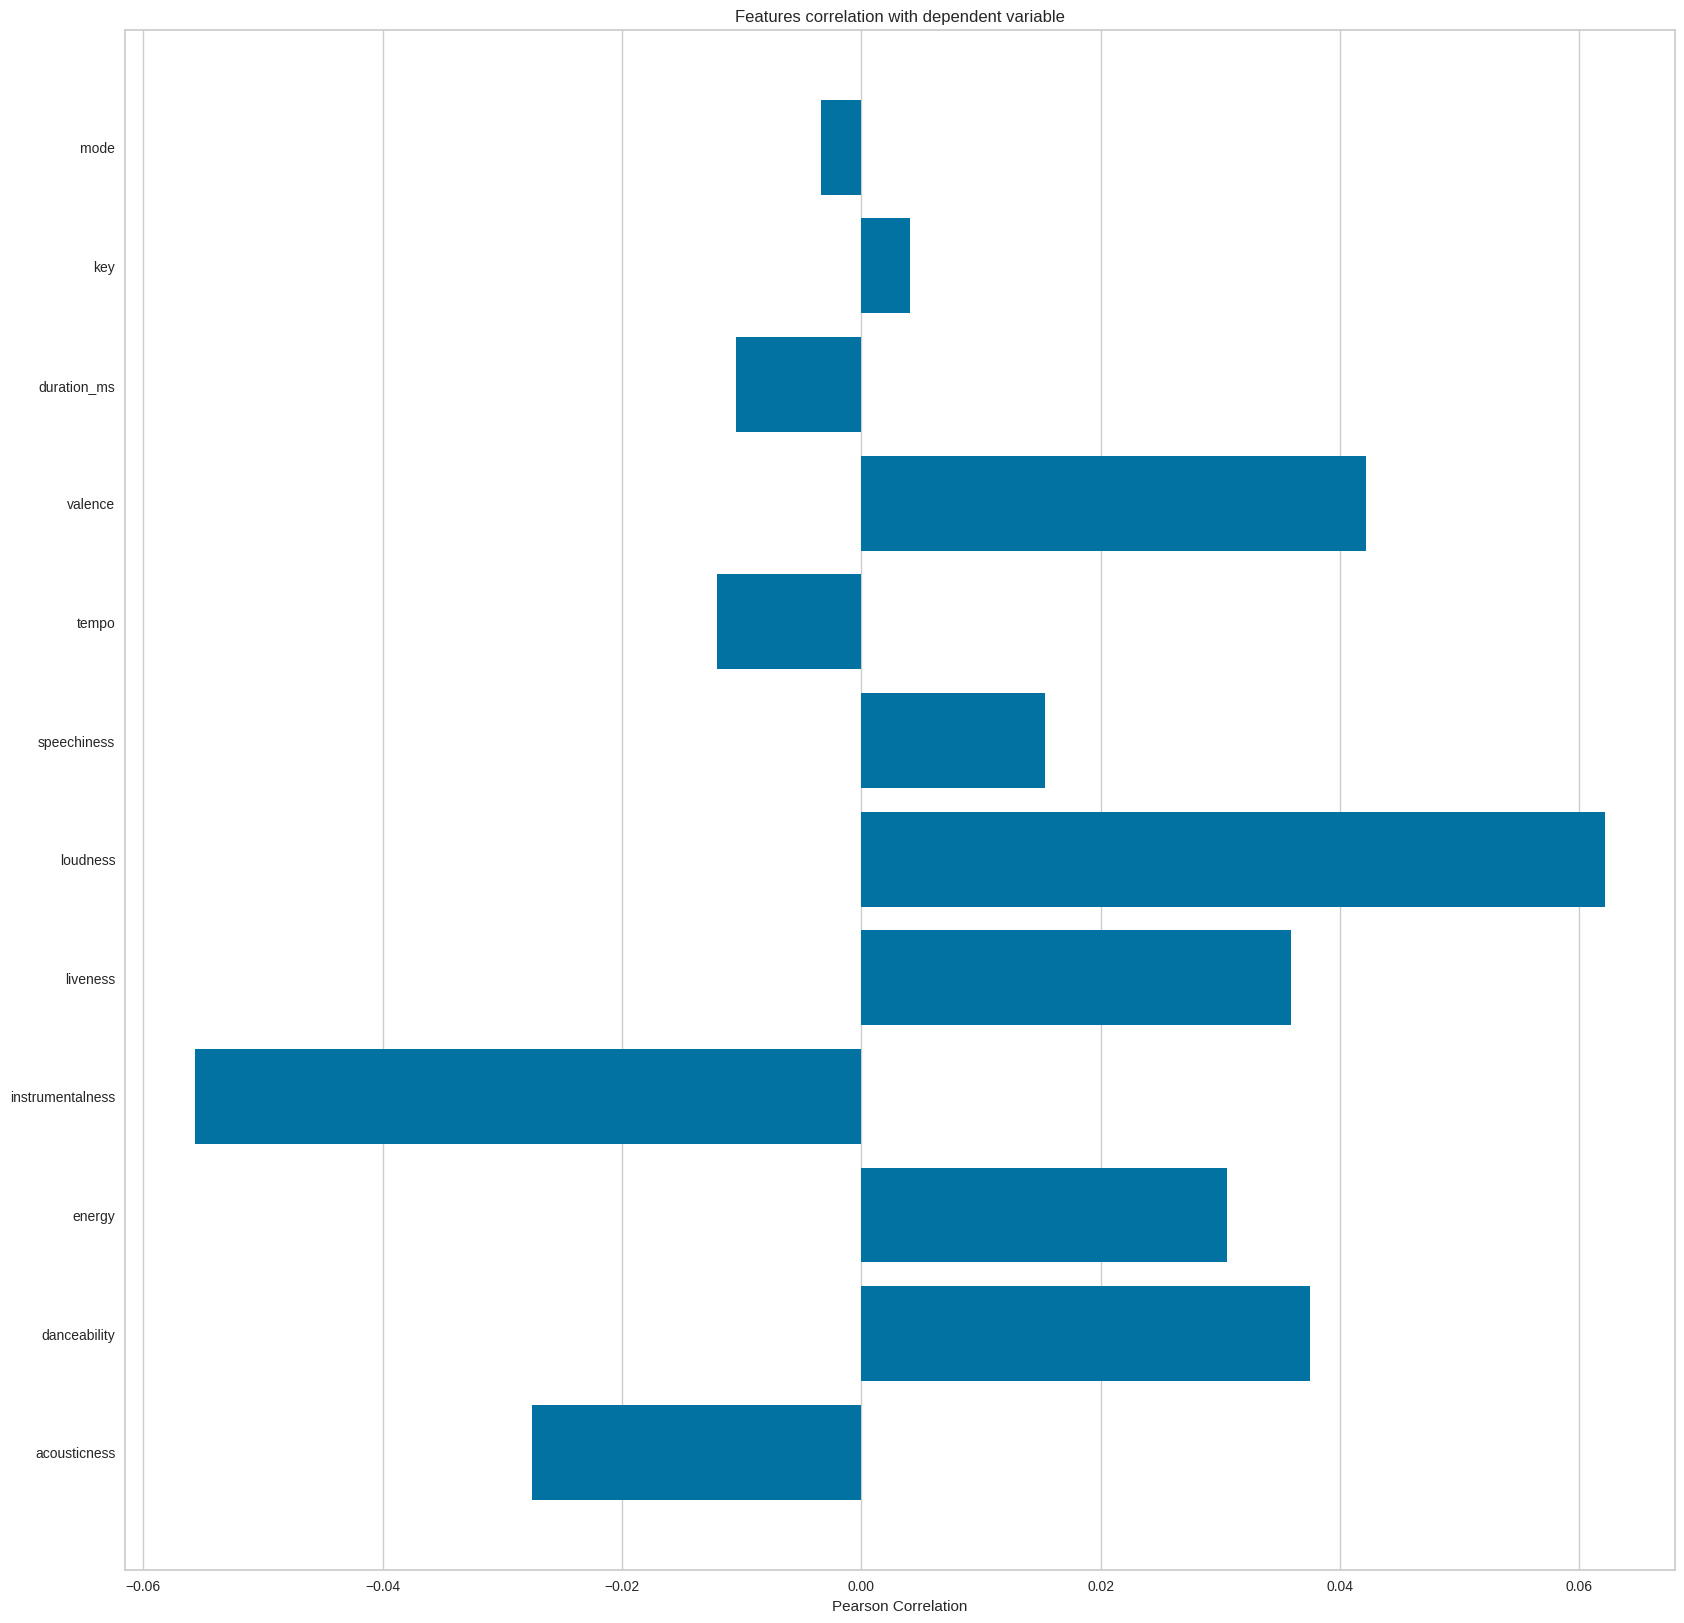

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
feature_names_genre = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','key','mode']

X, y = genre_data[feature_names_genre], LabelEncoder().fit_transform(genre_data['genres'])

# Create a list of the feature names
features = np.array(feature_names_genre)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

The genre properties that make a make a genre distinct - Danceability,  Liveness, Valence, Loudness, Energy, Valence

# **Clustering**


We try making clusters for Genres based on the selected acoustic properties and evaluate it. 

We also perform clustering of the songs based on the selected features against the popularity metric 




## **Clustering songs into genres(data.csv)**

In [ ]:
relevant_genre_features = ['danceability','liveness', 'valence', 'loudness', 'energy']

Using elbow method to find k

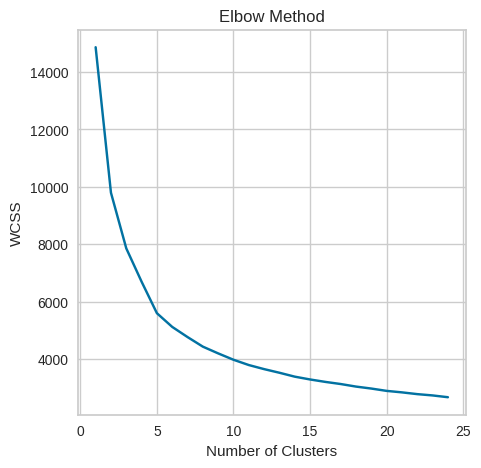

In [ ]:
optimal_cluster_elbow_method(genre_data[relevant_genre_features])

In [ ]:
genre_data_filtered = genre_data[relevant_genre_features]
genre_data_filtered.head(5)

danceability  liveness   valence   loudness    energy
0      0.162883  0.361600  0.103783 -31.514333  0.071317
1      0.299333  0.131000  0.221750 -16.854000  0.450678
2      0.712000  0.126000  0.975000  -9.180000  0.818000
3      0.538961  0.172254  0.448249 -12.479387  0.316434
4      0.516167  0.118067  0.307325 -15.472083  0.442417

In [ ]:
genre_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=5))])
X = genre_data_filtered
genre_cluster_pipeline.fit(X)
genre_data['cluster_id'] = genre_cluster_pipeline.predict(X)
genre_data_filtered['cluster_id'] = genre_cluster_pipeline.predict(X)
genre_data.head(20)

mode                  genres  acousticness  danceability   duration_ms  \
0      1  21st century classical      0.979333      0.162883  1.602977e+05   
1      1                   432hz      0.494780      0.299333  1.048887e+06   
2      1                   8-bit      0.762000      0.712000  1.151770e+05   
3      1              a cappella      0.676557      0.538961  1.906285e+05   
4      1                abstract      0.459210      0.516167  3.431965e+05   
5      1          abstract beats      0.342147      0.623000  2.299362e+05   
6      1        abstract hip hop      0.243854      0.694571  2.318492e+05   
7      0               accordeon      0.323000      0.588000  1.640000e+05   
8      1               accordion      0.446125      0.624812  1.670616e+05   
9      0              acid house      0.067951      0.677400  2.971881e+05   
10     1               acid rock      0.256915      0.447239  2.592039e+05   
11     1             acid trance      0.006830      0.663000  2.211600e+05   
12     1              acousmatic      0.917019      0.420458  1.850403e+05   
13     1          acoustic blues      0.761724      0.606915  2.043213e+05   
14     1            acoustic pop      0.490235      0.535108  2.353798e+05   
15     1           acoustic punk      0.404900      0.539112  1.923321e+05   
16     1           acoustic rock      0.613201      0.524397  1.950360e+05   
17     0             action rock      0.229000      0.412000  1.984000e+05   
18     1               adoracion      0.432857      0.504714  3.029061e+05   
19     1         adult standards      0.655648      0.496328  1.973315e+05   

      energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0   0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1   0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2   0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3   0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   
4   0.442417          0.849667  0.118067 -15.472083     0.046517  127.885750   
5   0.527800          0.333603  0.099653  -7.918000     0.116373  112.413800   
6   0.646235          0.024231  0.168543  -7.349328     0.214258  108.244987   
7   0.392000          0.441000  0.079400 -14.899000     0.072700  109.131000   
8   0.373437          0.193738  0.160300 -14.487063     0.078537  112.872438   
9   0.724403          0.385891  0.233488  -9.381200     0.055855  126.492092   
10  0.580649          0.150926  0.230451 -11.433073     0.067600  125.659522   
11  0.925000          0.703000  0.185000  -6.775000     0.044900  132.687000   
12  0.238524          0.616248  0.261006 -20.964565     0.080618  104.074633   
13  0.360659          0.098918  0.183098 -12.554905     0.068815  113.284521   
14  0.476440          0.033338  0.157750  -9.297248     0.041771  117.887420   
15  0.615824          0.061940  0.209481  -8.010774     0.063571  122.308489   
16  0.416003          0.321475  0.140518 -10.540620     0.034681  122.655663   
17  0.938000          0.000259  0.106000  -0.253000     0.182000   97.489000   
18  0.520750          0.000000  0.315986  -8.010071     0.038204  130.710679   
19  0.382054          0.118194  0.196777 -12.221776     0.053158  113.381177   

     valence  popularity  key  cluster_id  
0   0.103783   27.833333    6           1  
1   0.221750   52.500000    5           1  
2   0.975000   48.000000    7           2  
3   0.448249   45.820071    7           3  
4   0.307325   43.500000    1           3  
5   0.493507   58.933333   10           2  
6   0.571391   39.790702    2           2  
7   0.709000   39.000000    2           3  
8   0.658688   21.937500    2           3  
9   0.567677   46.638462    7           2  
10  0.534447   32.675955    2           3  
11  0.843000   62.000000    9           2  
12  0.324447    9.342524    5           1  
13  0.633786   23.746060    7           3  
14  0.379415   53.115505

In [ ]:
# Visualizing the Clusters with t-SNE
X = genre_data_filtered
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['titles'] = genre_data['genres']
projection['cluster'] = genre_data['cluster_id']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'titles'])
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2972 samples in 0.004s...
[t-SNE] Computed neighbors for 2972 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2972
[t-SNE] Computed conditional probabilities for sample 2000 / 2972
[t-SNE] Computed conditional probabilities for sample 2972 / 2972
[t-SNE] Mean sigma: 0.361489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.212639
[t-SNE] KL divergence after 1000 iterations: 1.024541


We experimented with different values of K - 5,10,20,40

But we see that there is an overlap of genres and there is no clear distinction.

We disregard using the genre data from further on.

## **Clustering songs by popularity (data.csv)**

In [ ]:
relevant_song_features = ['explicit','tempo','loudness','energy','danceability']

In [ ]:
data_filtered = data[relevant_song_features]
data_filtered.head(5)

explicit    tempo  loudness  energy  danceability
0         0   87.430    -8.631   0.348         0.274
1         0   85.861    -9.430   0.285         0.421
2         0  154.759   -12.472   0.287         0.508
3         0   76.816    -7.570   0.502         0.579
4         0  116.112    -5.466   0.799         0.743

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=20))])
X = data_filtered
song_cluster_pipeline.fit(X)
data['cluster_label'] = song_cluster_pipeline.predict(X)
data_filtered['cluster_label'] = song_cluster_pipeline.predict(X)
data.head(5)

valence  year  acousticness              artists  danceability  \
0    0.328  1960         0.547       ['Etta James']         0.274   
1    0.402  1960         0.829       ['Etta James']         0.421   
2    0.644  1960         0.764  ['Ella Fitzgerald']         0.508   
3    0.836  1960         0.733  ['Ella Fitzgerald']         0.579   
4    0.965  1960         0.699      ['Neil Sedaka']         0.743   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       179693   0.348         0  4Hhv2vrOTy89HFRcjU3QOx          0.013300   
1       196133   0.285         0  0zGLlXbHlrAyBN1x6sY0rb          0.000002   
2       175987   0.287         0  4ukUoXLuFzMixyZyabSGc4          0.000000   
3       131733   0.502         0  65irrLqfCMRiO3p87P4C0D          0.000000   
4       139200   0.799         0  2x6pbpjVGjiWCcH89IK8AX          0.000000   

   ...  liveness  loudness  mode                       name popularity  \
0  ...    0.3340    -8.631     1                    At Last         76   
1  ...    0.2330    -9.430     0      A Sunday Kind Of Love         70   
2  ...    0.1530   -12.472     1                Sleigh Ride         69   
3  ...    0.2810    -7.570     1         Frosty The Snowman         69   
4  ...    0.0635    -5.466     0  Breaking Up Is Hard to Do         62   

   release_date speechiness    tempo  decade cluster_label  
0          1960      0.0293   87.430    1960             2  
1          1960      0.0293   85.861    1960             4  
2    1960-01-01      0.0523  154.759    1960             5  
3    1960-01-01      0.0513   76.816    1960             4  
4    1960-12-30      0.0375  116.112    1960             0  

[5 rows x 21 columns]

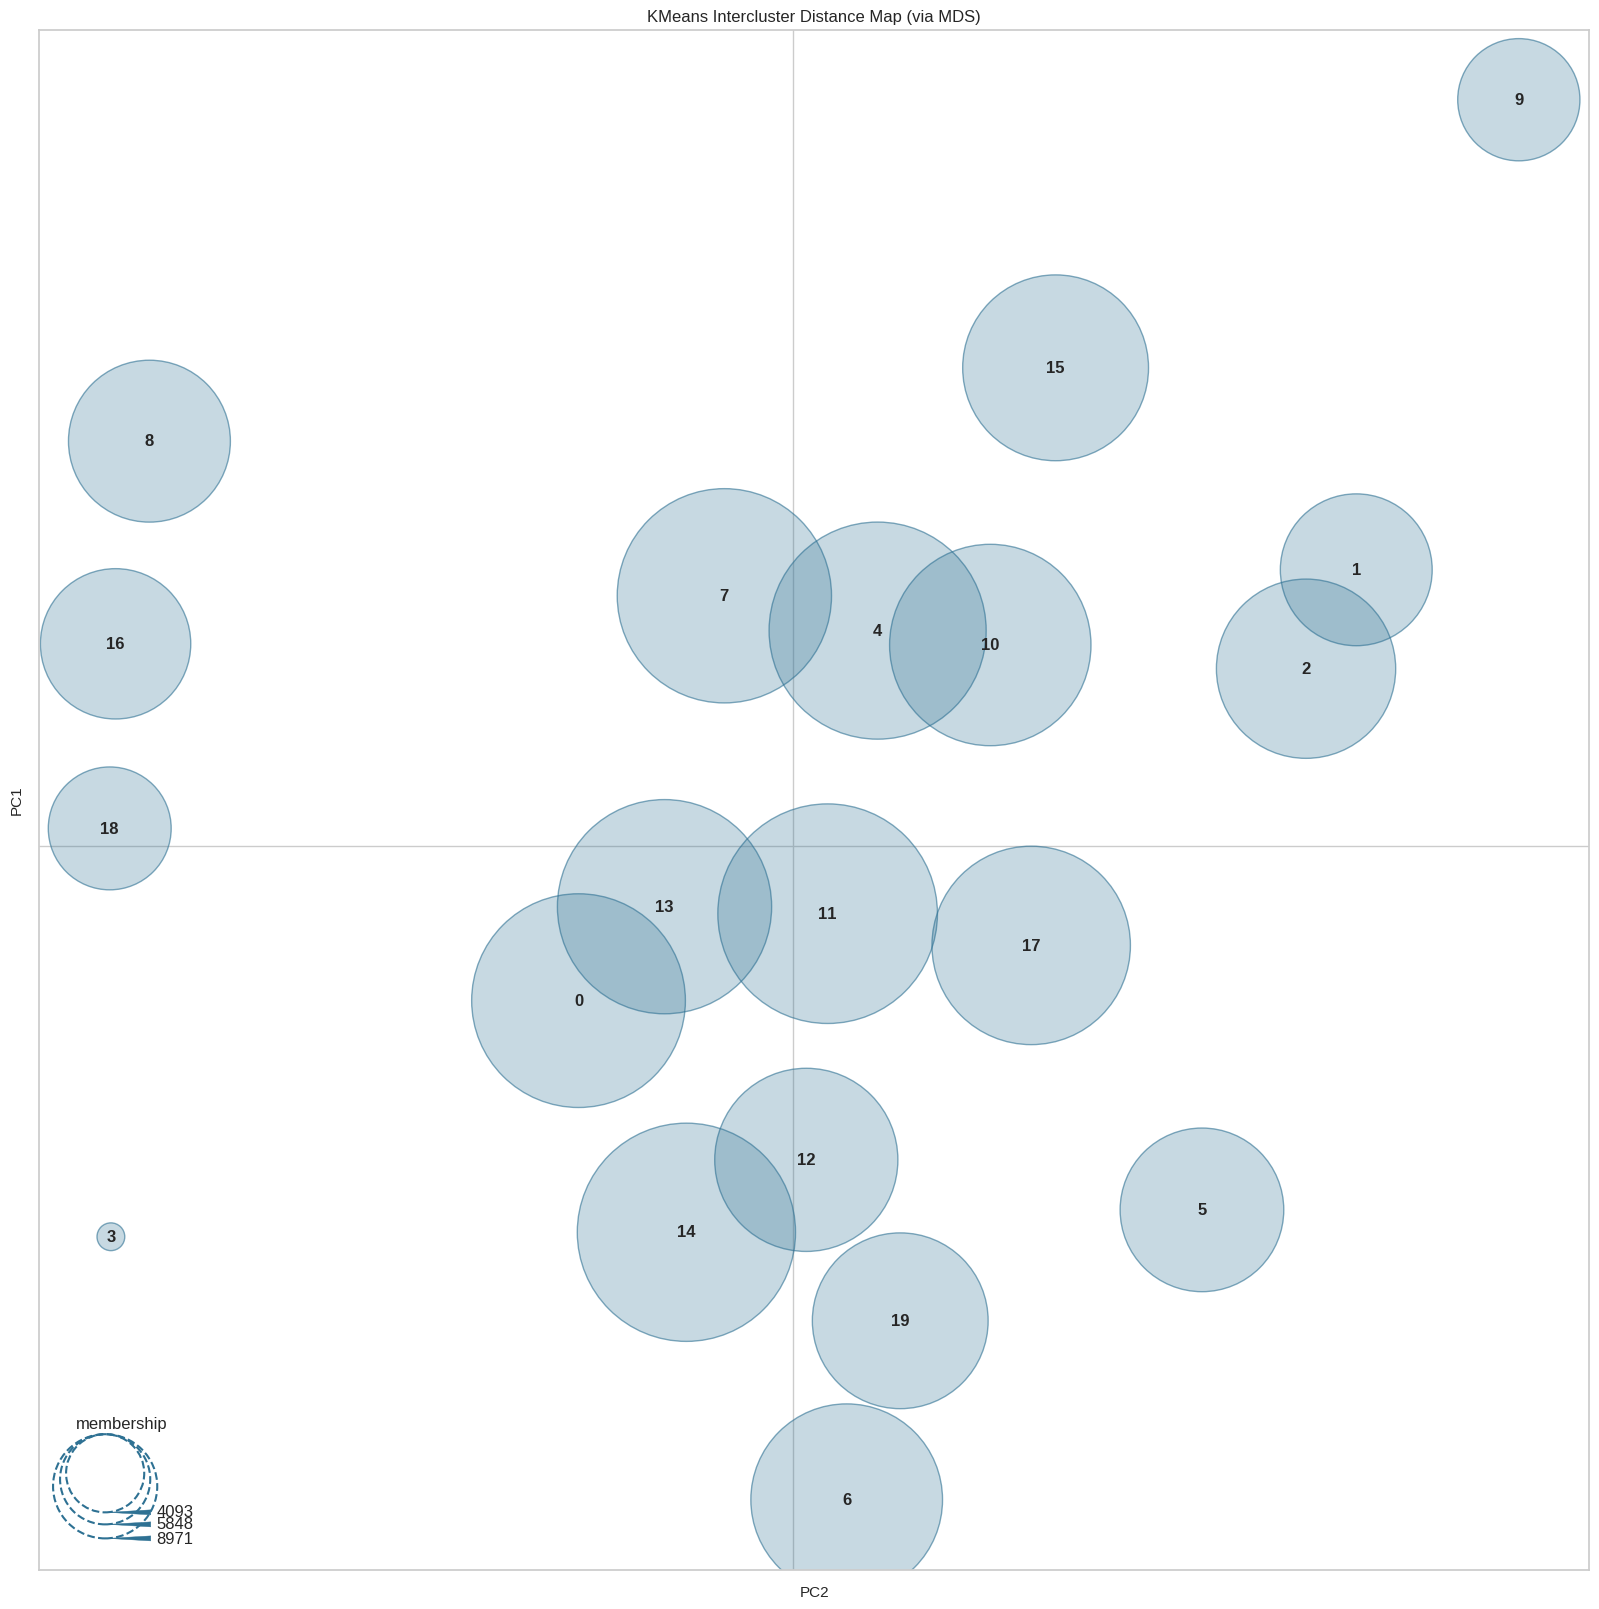

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
visualizer = InterclusterDistance(song_cluster_pipeline[1])
visualizer.fit(X)
visualizer.show()

In [ ]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

From the results above, we gather that this cluster is good for recommendation as popular songs are group together.

With experimentation we find that the best K=20

In [ ]:
data.head(5)

valence  year  acousticness              artists  danceability  \
0    0.328  1960         0.547       ['Etta James']         0.274   
1    0.402  1960         0.829       ['Etta James']         0.421   
2    0.644  1960         0.764  ['Ella Fitzgerald']         0.508   
3    0.836  1960         0.733  ['Ella Fitzgerald']         0.579   
4    0.965  1960         0.699      ['Neil Sedaka']         0.743   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       179693   0.348         0  4Hhv2vrOTy89HFRcjU3QOx          0.013300   
1       196133   0.285         0  0zGLlXbHlrAyBN1x6sY0rb          0.000002   
2       175987   0.287         0  4ukUoXLuFzMixyZyabSGc4          0.000000   
3       131733   0.502         0  65irrLqfCMRiO3p87P4C0D          0.000000   
4       139200   0.799         0  2x6pbpjVGjiWCcH89IK8AX          0.000000   

   ...  liveness  loudness  mode                       name popularity  \
0  ...    0.3340    -8.631     1                    At Last         76   
1  ...    0.2330    -9.430     0      A Sunday Kind Of Love         70   
2  ...    0.1530   -12.472     1                Sleigh Ride         69   
3  ...    0.2810    -7.570     1         Frosty The Snowman         69   
4  ...    0.0635    -5.466     0  Breaking Up Is Hard to Do         62   

   release_date speechiness    tempo  decade cluster_label  
0          1960      0.0293   87.430    1960             2  
1          1960      0.0293   85.861    1960             4  
2    1960-01-01      0.0523  154.759    1960             5  
3    1960-01-01      0.0513   76.816    1960             4  
4    1960-12-30      0.0375  116.112    1960             0  

[5 rows x 21 columns]

In [ ]:
feature_names= ['explicit','tempo','loudness','energy','danceability']

X = data[feature_names] 

song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)


number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

# **Classification**

Using the cluster labels from the above step, we use different classification algroithms, to recommend songs from the acoustic clusters we create.

In [ ]:
data['cluster_label'].value_counts()

12    9843
11    9699
7     9351
1     9056
8     8975
14    8816
16    7369
10    6702
4     6478
19    6008
18    5926
6     5368
0     5139
13    4235
17    4103
5     3470
2     3452
9     2548
15    2449
3     1763
Name: cluster_label, dtype: int64

In [ ]:
data.to_csv("clustered_song_data.csv", index=False)

X (120750, 5)
y (120750,)
Class=6, n=5368 (4.446%)
Class=7, n=9351 (7.744%)
Class=16, n=7369 (6.103%)
Class=14, n=8816 (7.301%)
Class=18, n=5926 (4.908%)
Class=13, n=4235 (3.507%)
Class=0, n=5139 (4.256%)
Class=1, n=9056 (7.500%)
Class=2, n=3452 (2.859%)
Class=11, n=9699 (8.032%)
Class=10, n=6702 (5.550%)
Class=8, n=8975 (7.433%)
Class=4, n=6478 (5.365%)
Class=15, n=2449 (2.028%)
Class=19, n=6008 (4.976%)
Class=12, n=9843 (8.152%)
Class=9, n=2548 (2.110%)
Class=5, n=3470 (2.874%)
Class=3, n=1763 (1.460%)
Class=17, n=4103 (3.398%)


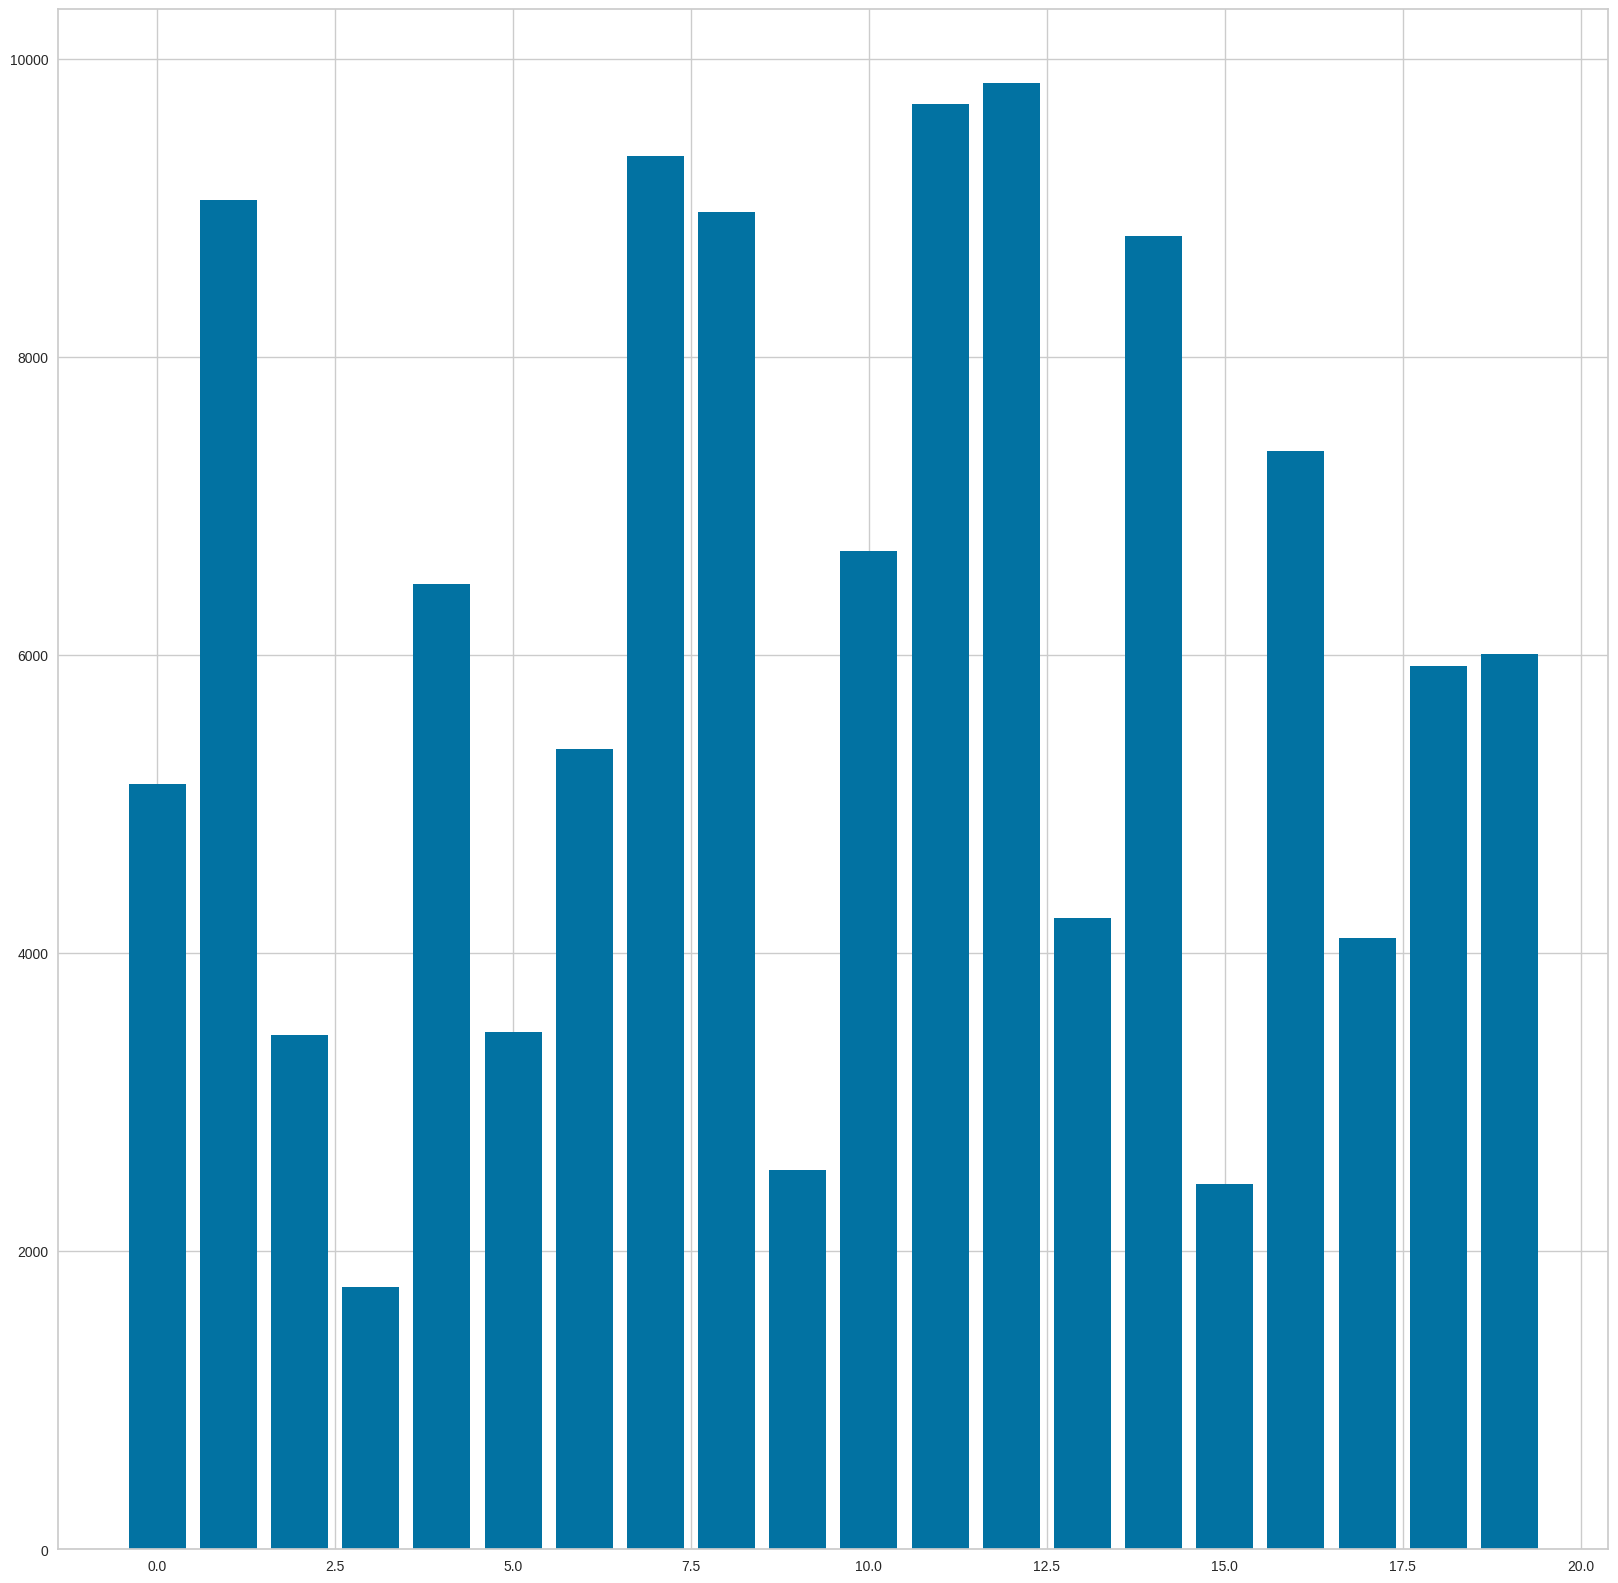

In [ ]:
relevant_song_features = ['explicit','tempo','loudness','energy','danceability']


X, y = data[relevant_song_features], data['cluster_label']

print('X',np.shape(X))

print('y',np.shape(y))

counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

We evaluate and experiment with different classifier. We determine our champion model after experimentation.

In [ ]:
# Create models

RANDOM_STATE=42

DecisionTreeClassifier_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
RandomForestClassifier_model = RandomForestClassifier(random_state=RANDOM_STATE)
LogisticRegression_model = LogisticRegression(random_state=RANDOM_STATE)
SVM_model = SVC(random_state=RANDOM_STATE)
SGDClassifier_model = SGDClassifier(random_state=RANDOM_STATE)
LinearSVC_model = LinearSVC(random_state=RANDOM_STATE) 

models = {
    'dtc': DecisionTreeClassifier_model,
    'rfc': RandomForestClassifier_model,
    'lr': LogisticRegression_model,
    'svm': SVM_model,
    'sgdc': SGDClassifier_model,
    'lsvc': LinearSVC_model
}

In [ ]:
# Create Pipelines

pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline([('scaler', StandardScaler()), ('pca', PCA(0.95)), ('model', model)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/5), random_state=42, stratify=y)

scores=[]
for name in pipelines.keys():
    clf = pipelines[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append([score,clf])

In [ ]:
scores

[[0.9303933747412009,
  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                  ('model', DecisionTreeClassifier(random_state=42))])],
 [0.9529192546583851,
  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                  ('model', RandomForestClassifier(random_state=42))])],
 [0.9544099378881987,
  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                  ('model', LogisticRegression(random_state=42))])],
 [0.9576811594202899,
  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                  ('model', SVC(random_state=42))])],
 [0.6493995859213251,
  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                  ('model', SGDClassifier(random_state=42))])],
 [0.8245962732919254,
  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                  ('model', LinearSVC(random_stat

In [ ]:
best_clf=max(scores)[1]

In [ ]:
best_clf

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model', SVC(random_state=42))])

In [ ]:
number_folds = 10
cv = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=42)


best_clf_f1_weighted = cross_validate(best_clf, X, y, cv=cv, scoring=('f1_weighted'))

In [ ]:
best_clf_f1_weighted

{'fit_time': array([24.06824517, 23.84384942, 23.22623587, 23.63833094, 22.53516006,
        22.3014605 , 22.80239105, 24.09234643, 23.73335457, 23.1903336 ]),
 'score_time': array([27.1938796 , 27.14910984, 26.86633015, 27.2143743 , 27.54023075,
        27.16089487, 27.26720309, 27.15959096, 27.61443543, 26.94462395]),
 'test_score': array([0.95874994, 0.95810462, 0.96036771, 0.95754823, 0.96070129,
        0.95365447, 0.95604831, 0.95884869, 0.95892776, 0.95728791])}

In [ ]:
print('f1_weighted: ' + str(best_clf_f1_weighted['test_score'].mean()))

f1_weighted: 0.9580238948224846


In [ ]:
best_clf.fit(X_train,y_train)

y_pred=best_clf.predict(X_test)


print(classification_report(y_test, y_pred))

print('cohen_kappa \n',cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1028
           1       0.96      0.97      0.96      1811
           2       0.97      0.97      0.97       690
           3       0.98      0.98      0.98       352
           4       0.97      0.96      0.97      1296
           5       0.97      0.98      0.98       694
           6       0.96      0.97      0.96      1074
           7       0.93      0.94      0.93      1870
           8       0.96      0.97      0.96      1795
           9       0.97      0.98      0.98       509
          10       0.92      0.92      0.92      1340
          11       0.94      0.94      0.94      1940
          12       0.97      0.97      0.97      1969
          13       0.97      0.96      0.96       847
          14       0.98      0.98      0.98      1763
          15       0.97      0.95      0.96       490
          16       0.96      0.94      0.95      1474
          17       0.99    

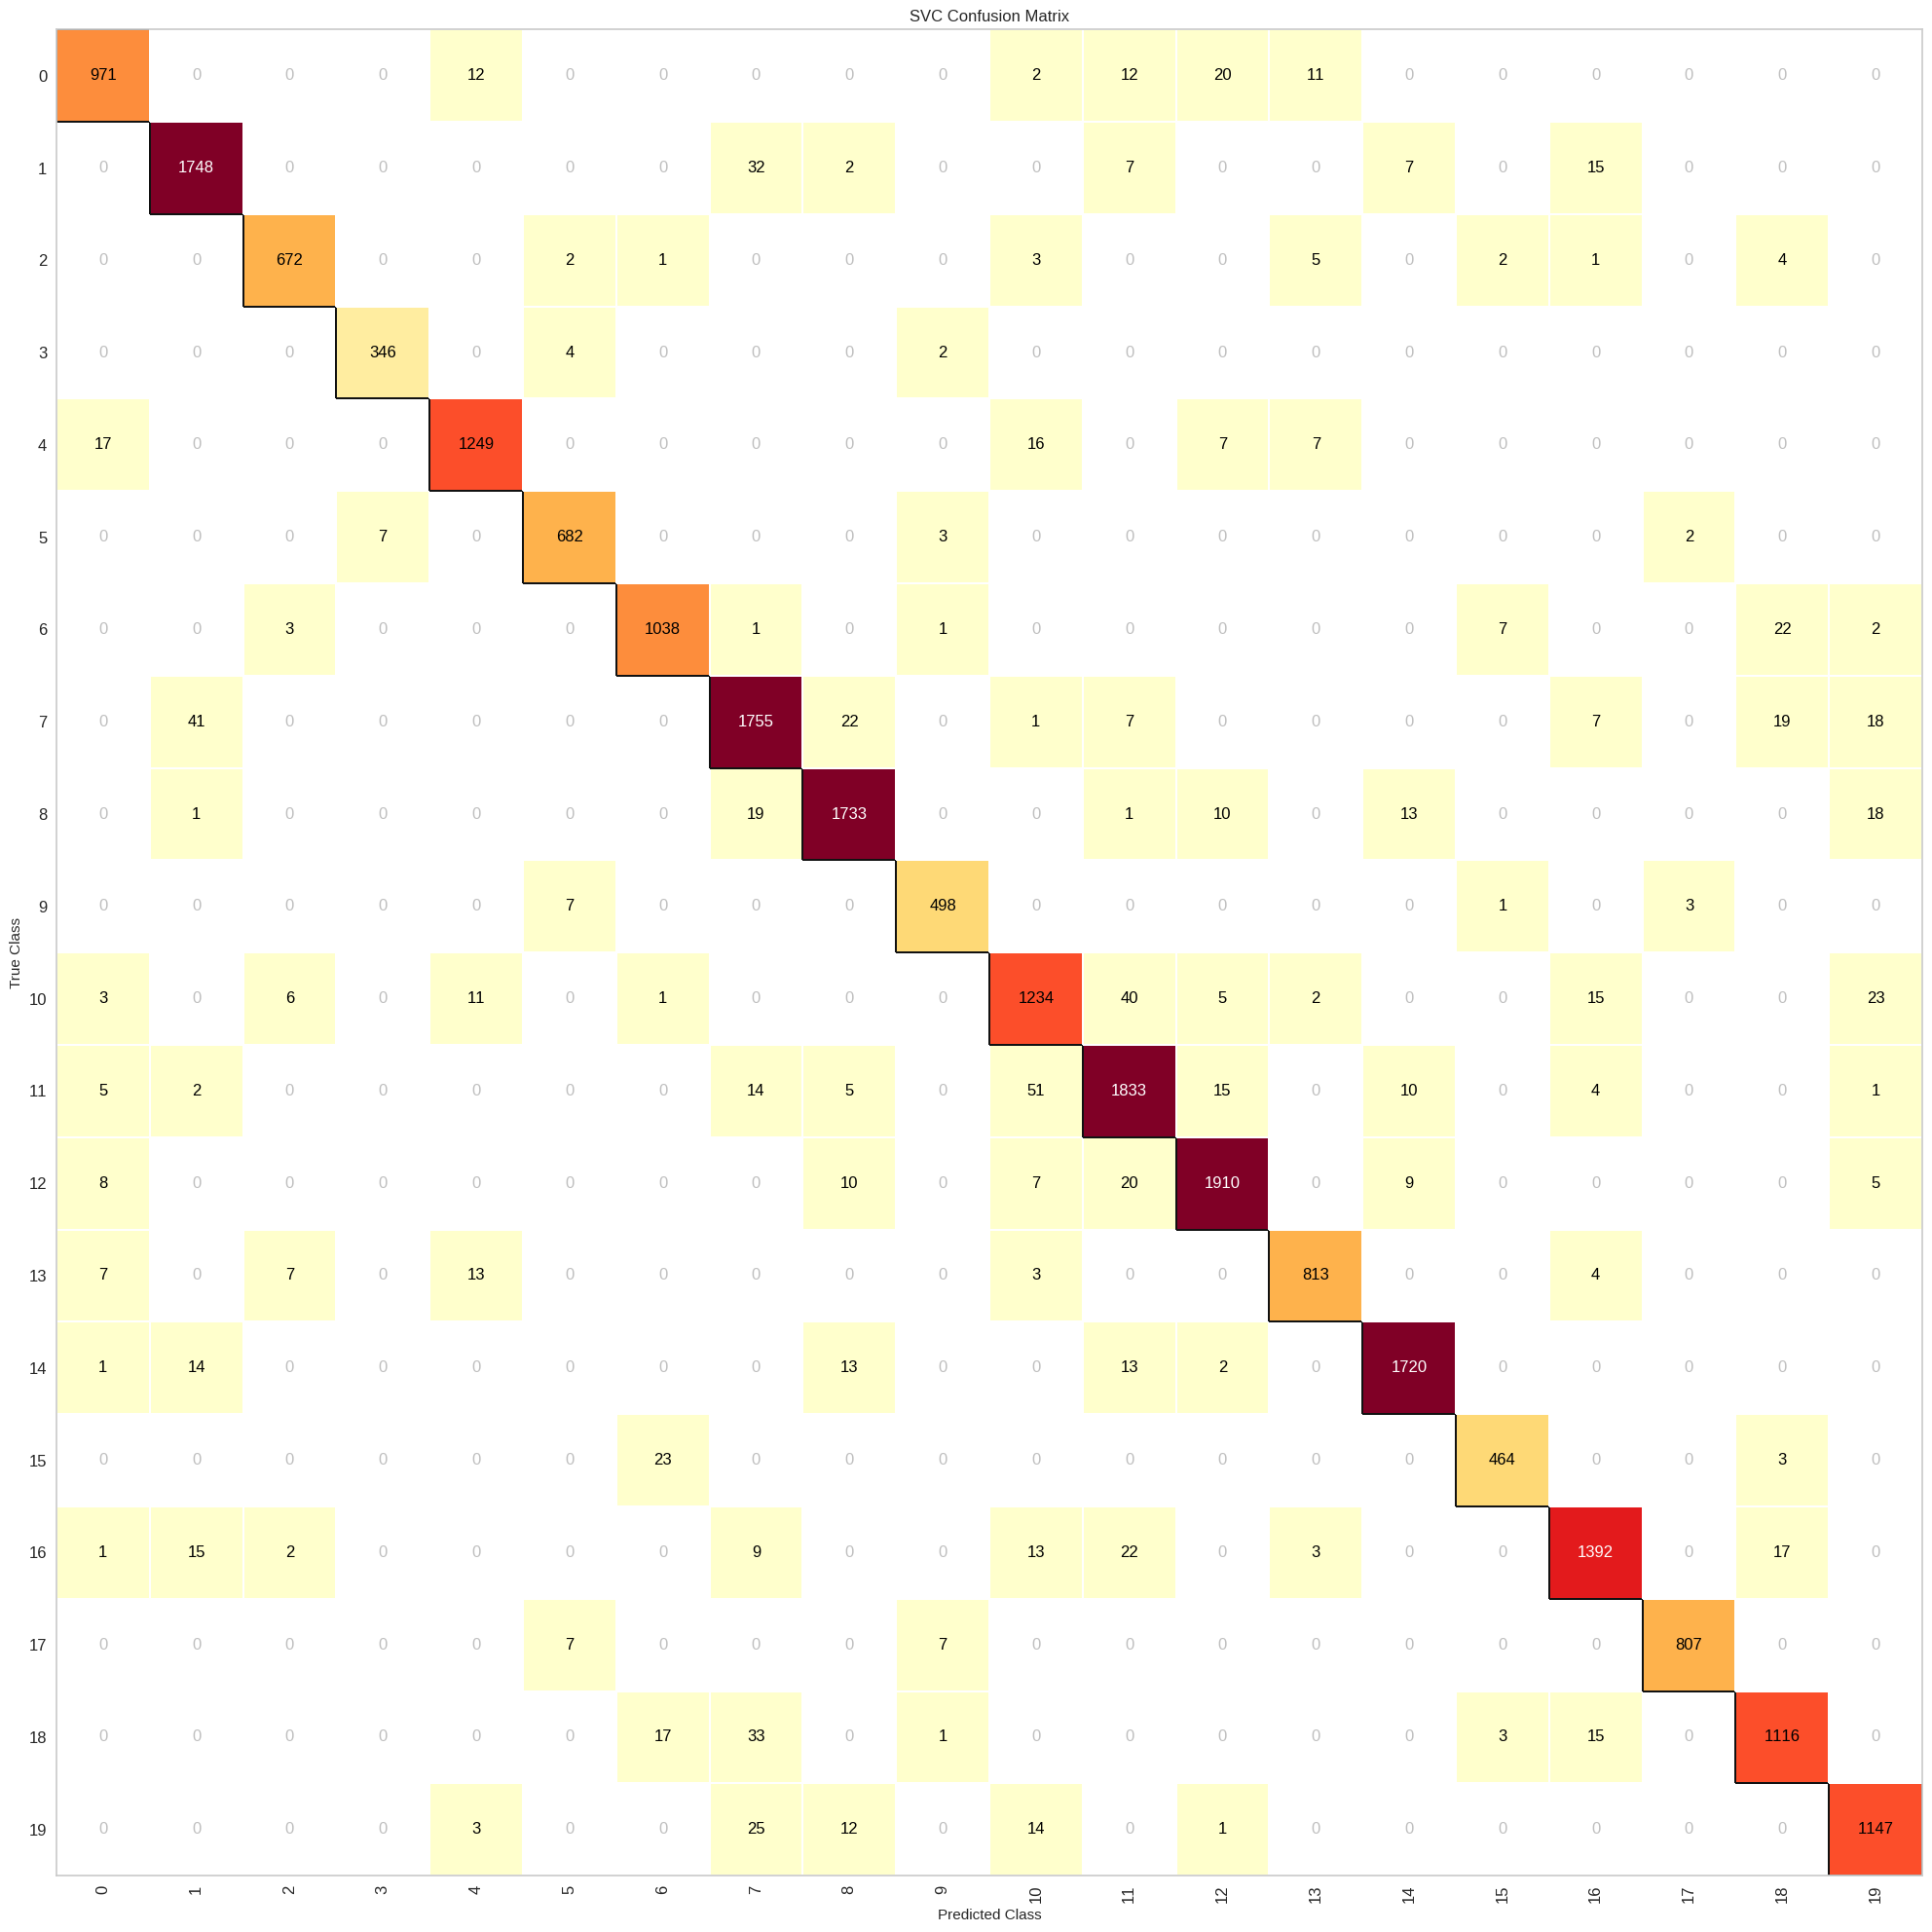

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
cm = ConfusionMatrix(best_clf, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [ ]:
joblibed_clf_model_filename = 'joblibed_clf_model.sav'
joblib.dump(best_clf, joblibed_clf_model_filename)

['joblibed_clf_model.sav']

In [ ]:
joblibed_clust_model_filename = 'joblibed_clust_model.sav'
joblib.dump(song_cluster_pipeline, joblibed_clust_model_filename)

['joblibed_clust_model.sav']

# **Recommend Song**

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='4d65d15e81a74678a7d664eb06c2b27c',
                                                           client_secret='9ee719d7e29545a5b562f8a99edbbf3c'))

def find_song(name, artist):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} artist: {}'.format(name,artist), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['artist'] = [artist]
    song_data['year'] = int(results['album']['release_date'][:4])
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [ ]:
number_cols = ['explicit','tempo','loudness','energy','danceability']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['artists'] == song['artist'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['artist'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)

    #predicting the cluster group the song belongs to
    clust=best_clf.predict(song_center.reshape(1, -1)) 
    #print(clust)

    # slicing the song dataframe to only the cluster predicted
    clust_group=spotify_data.loc[spotify_data['cluster_label'] == int(clust)] 
    #print(len(clust_group))

    #scaling the data frame
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(clust_group[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))


    # using cdist to find top 10 songs that are similar to the requested song
    distances = cdist(scaled_song_center, scaled_data, 'cosine') 
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = clust_group.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
recommend_songs([{'name': 'despacito', 'artist':'Luis Fonsi'}] ,data)

[{'name': 'Despacito',
  'year': 2019,
  'artists': "['Luis Fonsi', 'Daddy Yankee']"},
 {'name': 'Despacito - Remix',
  'year': 2019,
  'artists': "['Luis Fonsi', 'Daddy Yankee', 'Justin Bieber']"},
 {'name': 'Despacito - Remix',
  'year': 2017,
  'artists': "['Luis Fonsi', 'Daddy Yankee', 'Justin Bieber']"},
 {'name': 'Te Amo Tanto', 'year': 2009, 'artists': "['Flex']"},
 {'name': "Live At E's", 'year': 1991, 'artists': "['Sublime']"},
 {'name': 'I Believe', 'year': 1994, 'artists': "['Sounds Of Blackness']"},
 {'name': 'Eh, Eh (Nothing Else I Can Say)',
  'year': 2008,
  'artists': "['Lady Gaga']"},
 {'name': 'My Ordinary Life',
  'year': 2017,
  'artists': "['The Living Tombstone']"},
 {'name': 'Por Favor Señora', 'year': 2003, 'artists': "['Maelo Ruiz']"},
 {'name': "Honey, I'm Home", 'year': 1997, 'artists': "['Shania Twain']"}]